In [6]:
import pandas as pd
import numpy as np
import os

dir_path = os.path.abspath('') #os.path.dirname(os.path.realpath(__file__))
FILE = dir_path + '/acqua_dati.csv'
fr = pd.read_csv(FILE)

p1 = np.array(fr['p1']) * 1000 # kPa -> Pa
p2 = np.array(fr['p2']) * 1000
p3 = np.array(fr['p3']) * 1000
p4 = np.array(fr['p4']) * 1000
R = np.array(fr['R']) # m^3/s

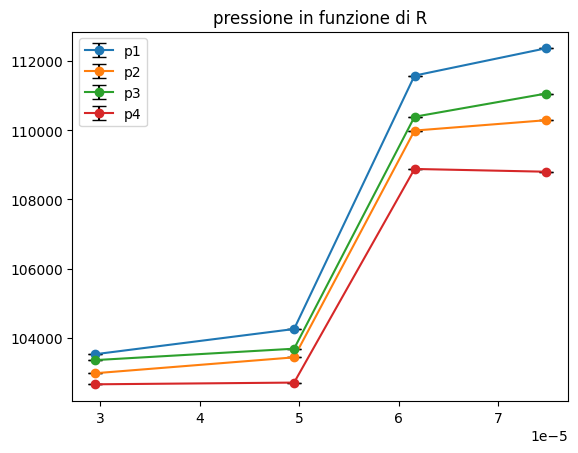

In [7]:
import matplotlib.pyplot as plt

plt.title('pressione in funzione di R')
plt.errorbar(R,p1,fmt='o-',yerr=0.01,capsize=5, ecolor='black',label='p1')
plt.errorbar(R,p2,fmt='o-',yerr=0.01,capsize=5, ecolor='black',label='p2')
plt.errorbar(R,p3,fmt='o-',yerr=0.01,capsize=5, ecolor='black',label='p3')
plt.errorbar(R,p4,fmt='o-',yerr=0.01,capsize=5, ecolor='black',label='p4')
plt.legend()

anche qui i nostri avventurieri si resero conto di aver compiuto lo stesso errore di aria.
Dopo aver consumato metà dello scottex gentilmente offerto dall'università continuarono la raccolta dati...

In [8]:
import pandas as pd
import numpy as np
import os

dir_path = os.path.abspath('') #os.path.dirname(os.path.realpath(__file__))
FILE = dir_path + '/acqua_dati_2.csv'
fr = pd.read_csv(FILE)

p1 = np.array(fr['p1']) * 1000 # kPa -> Pa
p2 = np.array(fr['p2']) * 1000
p3 = np.array(fr['p3']) * 1000
p4 = np.array(fr['p4']) * 1000
R = np.array(fr['R']) # m^3/s

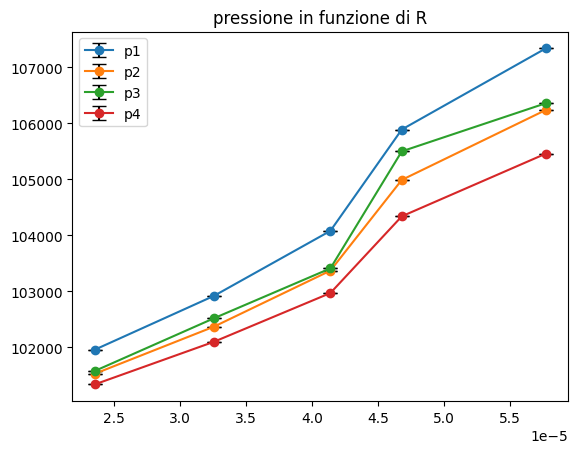

In [9]:
import matplotlib.pyplot as plt

plt.title('pressione in funzione di R')
plt.errorbar(R,p1,fmt='o-',yerr=0.01,capsize=5, ecolor='black',label='p1')
plt.errorbar(R,p2,fmt='o-',yerr=0.01,capsize=5, ecolor='black',label='p2')
plt.errorbar(R,p3,fmt='o-',yerr=0.01,capsize=5, ecolor='black',label='p3')
plt.errorbar(R,p4,fmt='o-',yerr=0.01,capsize=5, ecolor='black',label='p4')
plt.legend()

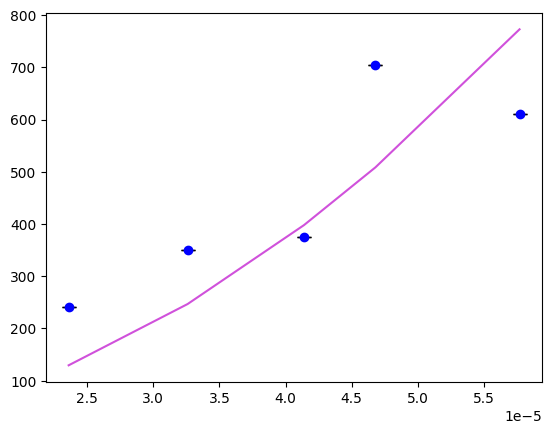

In [13]:
A_l = 1.99 / 10000 #cm^2 -> m^2 area larga
A_s = 0.452 / 10000 # area stretta

p_l = p1
p_S = p2 + (p1 - p3)/2
P_osservato = p_l - p_S

v_l = R / A_l
v_s = R / A_s
d_acqua = 1000 # kg/m^3
P_attesi = 0.5 * d_acqua * ((1/A_s)**2 - (1/A_l)**2) * R**2 

# TODO: cambiare yerr
plt.errorbar(R,P_osservato,fmt='o',yerr=0,capsize=5, ecolor='black',label='$\Delta p$',color='blue')
plt.plot(R,P_attesi,color='#d051db')